Install and import dependencies

In [ ]:
!pip install -r requirements.txt

In [1]:
import hdbscan
import apache_beam as beam
import numpy as np
import pandas as pd

import torch

from apache_beam import dataframe
from apache_beam.ml.inference.base import RunInference, PredictionResult
from apache_beam.ml.inference.sklearn_inference import SklearnModelHandlerNumpy
from apache_beam.ml.inference.sklearn_inference import ModelFileType
from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
from apache_beam.ml.inference.pytorch_inference import PytorchModelHandlerTensor, _convert_to_result
from apache_beam.ml.inference.base import KeyedModelHandler
from autoembedder import Autoembedder
import apache_beam.runners.interactive.interactive_beam as ib

In [2]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('dtc_opportunity.csv')
train, test = train_test_split(data, test_size=0.33, random_state=21)
train.to_csv('dtc_opportunity_train.csv', index=False)
test.to_csv('dtc_opportunity_test.csv', index=False)

# pretrained_embedder_path = f"gs://{PROJECT_ID}-ml-examples/{MODEL_NAME}/pytorch_model.bin"
# pretrained_anomaly_detection_path = f"gs://{PROJECT_ID}-ml-examples/{MODEL_NAME}/pytorch_model.bin"

Function for one-hot encoding the data. Convert the categorical columns to numerical

In [29]:
def get_one_hot_encoding(df, col) -> pd.DataFrame:
    beam_df_categorical = df[col]
    with dataframe.allow_non_parallel_operations():
        unique_classes = pd.CategoricalDtype(ib.collect(beam_df_categorical.unique(as_series=True)))
    beam_df_categorical = beam_df_categorical.astype(unique_classes).str.get_dummies()
    beam_df_categorical = beam_df_categorical.add_prefix(f'{col}___')

    return beam_df_categorical

### Custom wrappers for embedding and clustering models
These custom handlers are used to determine the way the data processed before the input to RunInference:
1. For anomaly detection model
2. For PyTorch model

In [30]:
class CustomSklearnModelHandlerNumpy(SklearnModelHandlerNumpy):
    def run_inference(self, batch, model, inference_args=None):
        predictions = hdbscan.approximate_predict(model, batch)
        return [PredictionResult(x, y) for x, y in zip(batch, predictions[0])]

In [31]:
class CustomPytorchModelHandlerTensor(PytorchModelHandlerTensor):
    def run_inference(self, batch, model, inference_args=None):
        with torch.no_grad():
            list_of_cont_tensors = []
            list_of_cat_tensors = []
            for item in batch:
                list_of_cont_tensors.append(item['cont_cols'])
                list_of_cat_tensors.append(item['cat_cols'])

            batched_tensors_cont = torch.stack(list_of_cont_tensors).view(1, -1)
            batched_tensors_cat = torch.stack(list_of_cat_tensors).T

            model(x_cont=batched_tensors_cont, x_cat=batched_tensors_cat)
            predictions = model.code_value
            return _convert_to_result(batch, predictions)

    def get_num_bytes(self, batch) -> int:
        return sum((el[key].element_size() for el in batch for key in el.keys()))

Decode predictions ParDo

In [32]:
class DecodePrediction(beam.DoFn):
    def process(self, element):
        uid, prediction = element
        cluster = prediction.inference.tolist()
        bq_dict = {"id": uid, "cluster": cluster}
        yield bq_dict

Define model parameters

In [33]:
parameters = {
    "hidden_layers": [[25, 20], [20, 10]],
    "epochs": 10,
    "lr": 0.0001,
    "verbose": 1,
    "batch_size": 16,
}
list_cat = [(134, 127)]
num_cont_features = 1

In [34]:
anomaly_detection_model_handler = CustomSklearnModelHandlerNumpy(model_uri='pretrained/anomaly_detection.model',
                                                                 model_file_type=ModelFileType.JOBLIB)

encoder_handler = CustomPytorchModelHandlerTensor(state_dict_path='pretrained/encoder.pth',
                                            model_class=Autoembedder, model_params={'config': parameters, 'num_cont_features': num_cont_features, 'embedding_sizes': list_cat})

Construct and run the pipeline

In [35]:
def process_with_pipeline(data_csv, prepare_only_dataframe=False):
    with beam.Pipeline(InteractiveRunner()) as p:
        input_data = p | "Read CSV" >> beam.dataframe.io.read_csv(data_csv)
        # For now dropping dates
        input_data = input_data.drop(['Billing State/Province',
                                      'Created Date',
                                      'Close Date',
                                      'Account Name',
                                      'Product Name',
                                      'Opportunity Name'], axis=1)
        input_data = input_data.drop('#', axis=1)
        input_data = input_data.replace('-', 'HYPHEN', regex=True)
        input_data = input_data.replace('/', 'SLASH', regex=True)
        input_data = input_data.replace(' ', 'SPACE', regex=True)
        input_data = input_data.rename(columns={x: x.replace(' ', '_') for x in input_data.columns})


        with dataframe.allow_non_parallel_operations():
            input_data = input_data.dropna()

        numerical_cols = input_data.select_dtypes(include=np.number).columns.tolist()
        bool_cols = input_data.select_dtypes(include='bool').columns.tolist()

        categorical_cols = list(set(input_data.columns) - set(numerical_cols) - set(bool_cols))

        input_data_numericals = input_data.filter(items=numerical_cols)
        input_data_numericals = (input_data_numericals - input_data_numericals.mean())/input_data_numericals.std()

        processed_cat_columns = []

        for categorical_col in categorical_cols:
            input_data_categorical = get_one_hot_encoding(df=input_data, col=categorical_col)
            processed_cat_columns.extend(list(input_data_categorical.columns))
            input_data_numericals = input_data_numericals.merge(input_data_categorical, left_index=True, right_index=True)

        for bool_col in bool_cols:
            input_data_numericals = input_data_numericals.merge(input_data[bool_col].astype(int), left_index=True, right_index=True)

        if prepare_only_dataframe:
            print('Saving only test/train dataframes. Prediction pipeline aborted')
            aa = ib.collect(input_data_numericals)
            train = aa.sample(frac=0.8, random_state=42)
            test = aa.drop(train.index)
            train.to_csv('output_train_final.csv', index=False)
            test.to_csv('output_test_final.csv', index=False)
            return None


        input_data_numericals['id'] = input_data_numericals.index
        input_data_numericals = beam.dataframe.convert.to_pcollection(input_data_numericals)

        keyed_anomalies = (
                input_data_numericals
                | "Add id" >> beam.Map(lambda x: (x.id, {'cont_cols': torch.Tensor([getattr(x, f) for f in numerical_cols]),
                                                            'cat_cols': torch.tensor([getattr(x, f) for f in processed_cat_columns+bool_cols])}))
                | "Encode" >> RunInference(model_handler=KeyedModelHandler(encoder_handler))
                | "Concat features" >> beam.Map(lambda x: (x[0], x[1].inference.detach().numpy()))
                | "Detect anomaly" >> RunInference(model_handler=KeyedModelHandler(anomaly_detection_model_handler))
                | "Get predictions" >> beam.ParDo(DecodePrediction())
                | "Write output" >> beam.io.textio.WriteToText(file_path_prefix='prediction_output/shard')
        )

        return keyed_anomalies

Run the pipeline on the test data

In [36]:
process_with_pipeline(data_csv='dtc_opportunity_test.csv')

C:\Users\Marko\Desktop\Projects\DnA_accelerators\python-runinference\venv\lib\site-packages\apache_beam\dataframe\frame_base.py:145: RuntimeWarning: invalid value encountered in scalar divide
  lambda left, right: getattr(left, op)(right), name=op, args=[other])


Set model config: {'hidden_layers': [[25, 20], [20, 10]], 'epochs': 10, 'lr': 0.0001, 'verbose': 1, 'batch_size': 16}
Model `in_features`: 128


<PCollection[[36]: Write output/Write/WriteImpl/FinalizeWrite.None] at 0x23eaa20c1f0>

Display the data

In [22]:
import json
result = []
with open("prediction_output/shard-00000-of-00001") as f:
    for line in f:
        line = line.replace("'", '"')
        result.append(json.loads(line))

In [25]:
result_df = pd.DataFrame.from_dict(result)

<AxesSubplot: xlabel='cluster'>

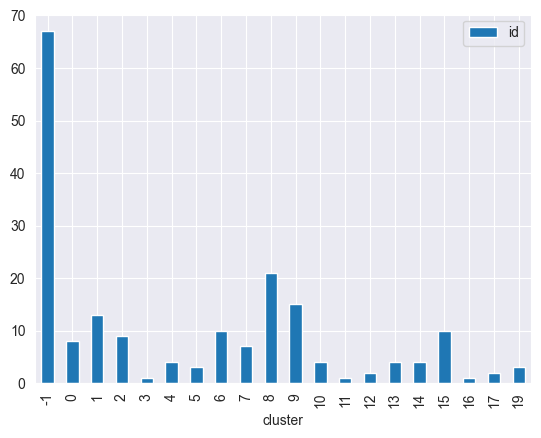

In [35]:
result_df.groupby([result_df['cluster']]).count().plot(kind='bar')